In [1]:
import os

import numpy as np
import pandas as pd

from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import cv2
import scipy
import scipy.io

Using TensorFlow backend.
c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:

In [2]:
# Suppress warning and informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Get count of number of files in this folder and all subfolders
def get_num_files(path):
  if not os.path.exists(path):
    return 0
  return sum([len(files) for r, d, files in os.walk(path)])

In [4]:
# Get count of number of subfolders directly below the folder in path
def get_num_subfolders(path):
  if not os.path.exists(path):
    return 0
  return sum([len(d) for r, d, files in os.walk(path)])

In [5]:
#   Define image generators that will variations of image with the image r/otated slightly, shifted up, down, left, or right, 
#     sheared, zoomed in, or flipped horizontally on the vertical axis (ie. person looking to the left ends up looking to the right)
def create_img_generator():
  return  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      horizontal_flip=True
  )

In [6]:
# Main Code
Image_width, Image_height = 224, 224 
Training_Epochs = 256
Batch_Size = 32
Number_FC_Neurons = 1024

train_dir = r'./../Storage/train'
validate_dir = r'./../Storage/valid'
num_train_samples = get_num_files(train_dir) 
num_classes = get_num_subfolders(train_dir)
num_validate_samples = get_num_files(validate_dir)
num_epoch = Training_Epochs
batch_size = Batch_Size

In [7]:
# Define data pre-processing 
#   Define image generators for training and testing 
train_image_gen = create_img_generator()
test_image_gen = create_img_generator()

In [8]:
#   Connect the image generator to a folder contains the source images the image generator alters.  
#   Training image generator
train_generator = train_image_gen.flow_from_directory(
  train_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed = 42    #set seed for reproducability
)

Found 6552 images belonging to 102 classes.


In [9]:
#   Validation image generator
validation_generator = test_image_gen.flow_from_directory(
  validate_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed=42       #set seed for reproducability
)

Found 818 images belonging to 102 classes.


In [10]:
# Load the Inception V3 model and load it with it's pre-trained weights.  But exclude the final 
#    Fully Connected layer
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
print('ResNet50 base model without last FC loaded')
#print(ResNet50_base_model.summary())     # display the Inception V3 model hierarchy

c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


ResNet50 base model without last FC loaded


In [28]:
# Define the layers in the new classification prediction 
x = ResNet50_base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(Number_FC_Neurons, activation='relu')(x)        # new FC layer, random init
predictions = Dense(num_classes, activation='softmax')(x)  # new softmax layer

In [29]:
# Define trainable model which links input from the Inception V3 base model to the new classification prediction layers
model = Model(inputs=ResNet50_base_model.input, outputs=predictions)

In [30]:
# print model structure diagram
print (model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [31]:
# Option 1: Basic Transfer Learning
print ('\nPerforming Transfer Learning')
  #   Freeze all layers in the Inception V3 base model 
for layer in ResNet50_base_model.layers:
  layer.trainable = False


Performing Transfer Learning


In [32]:
#   Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
#Model Check point
checkpoint = ModelCheckpoint('resnet50_best_model_copy2.h5',
                            monitor='va_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='min')
earlystopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=100)

In [39]:
# Fit the transfer learning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from 
# the training or validation folders and alter them slightly
history_transfer_learning = model.fit_generator(
  train_generator,
  epochs=num_epoch,
  steps_per_epoch = num_train_samples // batch_size,
  validation_data=validation_generator,
  validation_steps = num_validate_samples // batch_size,
  class_weight='auto',
  callbacks=[earlystopping, checkpoint])

Epoch 1/256
204/204 [==============================] - 82s 400ms/step - loss: 0.2766 - accuracy: 0.9741 - val_loss: 13.8055 - val_accuracy: 0.5275
Epoch 2/256
204/204 [==============================] - 82s 400ms/step - loss: 0.2677 - accuracy: 0.9732 - val_loss: 9.9637 - val_accuracy: 0.5242
Epoch 3/256
204/204 [==============================] - 82s 400ms/step - loss: 0.2533 - accuracy: 0.9721 - val_loss: 12.4418 - val_accuracy: 0.5318
Epoch 4/256
204/204 [==============================] - 82s 400ms/step - loss: 0.2414 - accuracy: 0.9740 - val_loss: 11.6457 - val_accuracy: 0.5980
Epoch 5/256
204/204 [==============================] - 81s 399ms/step - loss: 0.2545 - accuracy: 0.9721 - val_loss: 10.1065 - val_accuracy: 0.6272
Epoch 6/256
204/204 [==============================] - 82s 400ms/step - loss: 0.2227 - accuracy: 0.9753 - val_loss: 10.6196 - val_accuracy: 0.6094
Epoch 7/256
204/204 [==============================] - 82s 401ms/step - loss: 0.1740 - accuracy: 0.9794 - val_loss: 16.

KeyboardInterrupt: 

dict_keys(['val_loss', 'accuracy', 'loss', 'val_accuracy'])


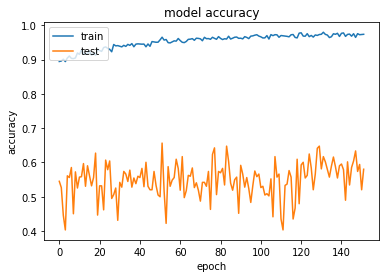

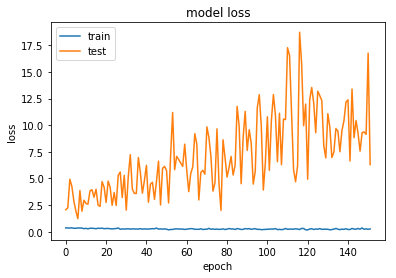

In [40]:
# list all data in history
print(history_transfer_learning.history.keys())
# summarize history for accuracy
plt.plot(history_transfer_learning.history['accuracy'])
plt.plot(history_transfer_learning.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_transfer_learning.history['loss'])
plt.plot(history_transfer_learning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
# Save transfer learning model
model.save('ResNet50-transfer-learning.model')

In [10]:
Training_Epochs = 1
num_epoch = Training_Epochs
#batch_size = Batch_Size

In [11]:
model = load_model('ResNet50-transfer-learning.model')

In [12]:
len(model.layers)

178

In [13]:
# Option 2: Transfer Learning with Fine-tuning - retrain the end few layers (called the top layers) of the inception model
print('\nFine tuning existing model')
#   Freeze 
Layers_To_Freeze = 45
for layer in model.layers[:Layers_To_Freeze]:
  layer.trainable = False
for layer in model.layers[Layers_To_Freeze:]:
  layer.trainable = True
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


Fine tuning existing model


In [14]:
# Fit the Fine-tuning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from the training or validation
# folders, alter then slightly, and pass the images back
history_fine_tune = model.fit_generator(
  train_generator,
  steps_per_epoch = num_train_samples // batch_size,
  epochs=num_epoch,
  validation_data=validation_generator,
  validation_steps = num_validate_samples // batch_size,
    class_weight='auto')

Epoch 1/1
204/204 [==============================] - 221s 1s/step - loss: 0.1241 - accuracy: 0.9900 - val_loss: 0.2345 - val_accuracy: 0.9000


In [15]:
# Save fine tuned model
model.save('ResNet50-fine-tune_90_percent_val_accuracy.model')

In [17]:
model = load_model('ResNet50-fine-tune_90_percent_val_accuracy.model')

In [11]:
from contextlib import redirect_stdout

with open('ResNet50-fine-tune_90_percent_val_accuracy_modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()

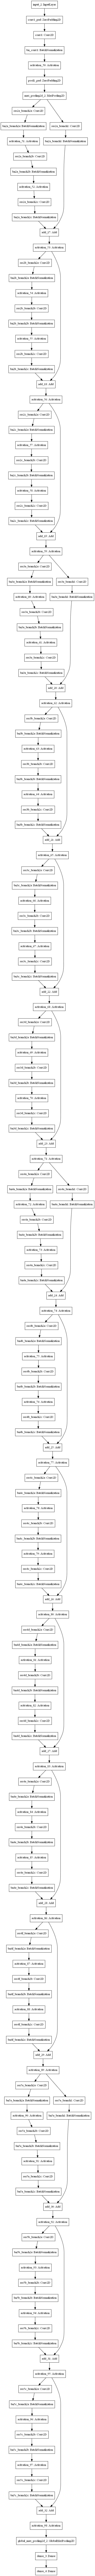

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='ResNet50-fine-tune_90_percent_val_accuracy_model.png')

In [9]:
# list all data in history
print(history_fine_tune.history.keys())
# summarize history for accuracy
plt.plot(history_fine_tune.history['accuracy'])
plt.plot(history_fine_tune.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: 'Model' object has no attribute 'history'

In [59]:
#   Validation image generator
test_datagen = ImageDataGenerator()
test_dir = r'./../Storage/test'

In [60]:
#   Validation image generator
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(Image_width, Image_height),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 873 images belonging to 1 classes.


In [61]:
test_generator.reset()

In [62]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [63]:
pred=model.predict_generator(test_generator,verbose=1,steps = np.ceil(nb_samples/batch_size))

28/28 [==============================] - 11s 410ms/step


In [64]:
predicted_class_indices=np.argmax(pred,axis=1)
print(len(set(predicted_class_indices)))
print(predicted_class_indices)

92
[ 77  77  77  77  77  77  77  77  77  77  77  77  77  77  77  77  77  77
  77  77  77  77  77  77  77  73  73  78 101  73  73  73  73  73  73  73
  35  76  73  78  73  73  73  73  73  73  35  73  73  82  73  73  73  74
  89  89  78  89  89  76  89  89  89  89  89  76  76  23  76   0  90  76
  76  90  87  90  90  90  84  49  49  82  82  82  82  82  82  82  82  82
  82  82  82  82  23  98  87 100  28  13  20  23  28  28  28  28  83  43
  97  87  28  23  20  23  87  74  74  95  91  23  74  35  23  74  76  23
  74  74  35  49 100  95  76  76 100  23 100  49  49  53  36  28  41  41
  41  41  41  41  41  41  41  41  41  83  83  41  41  83  30  41  83  83
  83  41  83  84  41  85  83  41  23  30  84  84  84 100  87  84  76  76
  84 100 100 100  78  78  78  78  78  78  78  78  78 101  35  78  78  78
  81  81  76  81  81  66  95  81 100  81  81  75   3  75  40  97  75  76
  75  75  75  75  81  76  38  38  38  17  38  38  38  38  65  38  38  38
  95  38  76  36  40  40  40  51  40  97  40  40

In [65]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels.values())
predictions = [labels[k] for k in predicted_class_indices]
print(predictions)
#print(len(set(predictions)))
#print(labels)

dict_values(['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'])
['77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '77', '73', '73', '78', '99', '73', '73', '73', '73', '73', '73', '73', '39', '76', '73', '78', '73', '73', '73', '73', '73', '73', '39', '73', '73', '81', '73', '73', '73', '74', '88', '88', '78', '88', '88', '76', '88', '88', '88', '

In [66]:
#imagelabels.mat contains labels of the images and number of images for each label
#labels and unique are the lists that contain the label ids and respective number of images 
mat = scipy.io.loadmat('imagelabels.mat')
labels_original = mat['labels'].tolist()
unique, counts = np.unique(labels_original, return_counts=True)

In [67]:
#find a flower label from flower image name
def find_flower_label_from_flower_image_name(flower_image_name):
    flower_id = flower_image_name.split('_')[1].split('.')[0]
    flower_id_int = int(flower_id)
    return labels_original[0][flower_id_int - 1]

In [68]:
true_labels = [find_flower_label_from_flower_image_name(name) for name in filenames]

In [69]:
print(true_labels)

[77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,

### Accuracy of the Flower Detection Model

In [70]:
from sklearn import metrics

In [71]:
#Accuracy of the prediction of flowers
print(metrics.accuracy_score(true_labels, predicted_class_indices, normalize=False))

87


In [72]:
#oxford102_flower_dataset_labels.txt contains a dataset where index is the unique label and column "Names" is the name of the flower for the image label id 
#read labels from oxford102_flower_dataset_labels.txt
oxford102_labels = pd.read_csv('oxford102_flower_dataset_labels.txt', delimiter='\t', header=None, names=['Names'])
# Image labels are 1 based, changed the index of the image database label
oxford102_labels.index = np.arange(1, len(oxford102_labels) + 1)

In [73]:
type(oxford102_labels.Names)

pandas.core.series.Series

In [74]:
#Confusion matrix
print(metrics.classification_report(true_labels, predicted_class_indices, target_names=oxford102_labels.Names.tolist()))

ValueError: Number of classes, 103, does not match size of target_names, 102. Try specifying the labels parameter

In [75]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [76]:
results

,Filename,Predictions
0,test\image_00005.jpg,77
1,test\image_00006.jpg,77
2,test\image_00024.jpg,77
3,test\image_00025.jpg,77
4,test\image_00029.jpg,77
...,...,...
868,test\image_08134.jpg,57
869,test\image_08144.jpg,83
870,test\image_08145.jpg,57
871,test\image_08172.jpg,84


In [77]:
type(results.Predictions.loc[1])

str

In [78]:
results.Predictions = results.Predictions.astype(np.int64)

In [79]:
type(results.Predictions.loc[1])

numpy.int64

In [80]:
results

,Filename,Predictions
0,test\image_00005.jpg,77
1,test\image_00006.jpg,77
2,test\image_00024.jpg,77
3,test\image_00025.jpg,77
4,test\image_00029.jpg,77
...,...,...
868,test\image_08134.jpg,57
869,test\image_08144.jpg,83
870,test\image_08145.jpg,57
871,test\image_08172.jpg,84


In [81]:
#oxford102_flower_dataset_labels.txt contains a dataset where index is the unique label and column "Names" is the name of the flower for the image label id 
#read labels from oxford102_flower_dataset_labels.txt
oxford102_labels = pd.read_csv('oxford102_flower_dataset_labels.txt', delimiter='\t', header=None, names=['Names'])
# Image labels are 1 based, changed the index of the image database label
oxford102_labels.index = np.arange(1, len(oxford102_labels) + 1)
print(oxford102_labels)
print()
print("Test Print: FLower Name and its unique label")
print(oxford102_labels.loc[77])

                            Names
1                 'pink primrose'
2     'hard-leaved pocket orchid'
3              'canterbury bells'
4                     'sweet pea'
5              'english marigold'
..                            ...
98              'mexican petunia'
99                     'bromelia'
100              'blanket flower'
101             'trumpet creeper'
102             'blackberry lily'

[102 rows x 1 columns]

Test Print: FLower Name and its unique label
Names     'passion flower'
Name: 77, dtype: object


In [82]:
oxford102_labels.reset_index(level=0, inplace=True)

In [83]:
oxford102_labels.head()

,index,Names
0,1,'pink primrose'
1,2,'hard-leaved pocket orchid'
2,3,'canterbury bells'
3,4,'sweet pea'
4,5,'english marigold'


In [84]:
oxford102_labels.rename({'index': 'Predictions'}, axis=1, inplace=True)

In [85]:
oxford102_labels.columns

Index(['Predictions', 'Names'], dtype='object')

In [86]:
merge_predictions = pd.merge(results, oxford102_labels, on='Predictions')

In [87]:
merge_predictions

,Filename,Predictions,Names
0,test\image_00005.jpg,77,'passion flower'
1,test\image_00006.jpg,77,'passion flower'
2,test\image_00024.jpg,77,'passion flower'
3,test\image_00025.jpg,77,'passion flower'
4,test\image_00029.jpg,77,'passion flower'
...,...,...,...
868,test\image_07936.jpg,100,'blanket flower'
869,test\image_07938.jpg,100,'blanket flower'
870,test\image_08004.jpg,102,'blackberry lily'
871,test\image_08015.jpg,102,'blackberry lily'


In [88]:
merge_predictions.loc[merge_predictions['Filename'] == 'test\image_07936.jpg']

,Filename,Predictions,Names
868,test\image_07936.jpg,100,'blanket flower'


In [89]:
oxford102_labels.loc[99]

Predictions                  100
Names           'blanket flower'
Name: 99, dtype: object

In [90]:
#imagelabels.mat contains labels of the images and number of images for each label
#labels and unique are the lists that contain the label ids and respective number of images 
mat = scipy.io.loadmat('imagelabels.mat')
labels = mat['labels'].tolist()
unique, counts = np.unique(labels, return_counts=True)

In [91]:
#find a flower label from flower image name
def find_flower_label_from_flower_image_name(flower_image_name):
    flower_id = flower_image_name.split('_')[1].split('.')[0]
    flower_id_int = int(flower_id)
    return labels[0][flower_id_int - 1]

In [92]:
#Find the name of the flower from the image name from the image database
def find_flower_category_name(file_path):
    flower_name = file_path.split("\\")[-1]
    flower_label = find_flower_label_from_flower_image_name(flower_name)
    flower_category_name = oxford102_labels.Names.loc[flower_label-1]
    return flower_category_name.replace("'", '').strip()

In [93]:
find_flower_category_name('test\image_07936.jpg')

'blanket flower'

In [94]:
test_images = results.Filename

In [95]:
type(test_images)

pandas.core.series.Series

In [96]:
list_actual_flower_name = []
for filename in test_images.items():
    actual_name = find_flower_category_name(filename[1])
    list_actual_flower_name.append(actual_name)

In [97]:
df = pd.DataFrame(list_actual_flower_name, columns = ['Actuals'])

In [98]:
merge_predictions['Actuals'] = list_actual_flower_name

In [99]:
merge_predictions

,Filename,Predictions,Names,Actuals
0,test\image_00005.jpg,77,'passion flower',passion flower
1,test\image_00006.jpg,77,'passion flower',passion flower
2,test\image_00024.jpg,77,'passion flower',passion flower
3,test\image_00025.jpg,77,'passion flower',passion flower
4,test\image_00029.jpg,77,'passion flower',passion flower
...,...,...,...,...
868,test\image_07936.jpg,100,'blanket flower',gaura
869,test\image_07938.jpg,100,'blanket flower',gaura
870,test\image_08004.jpg,102,'blackberry lily',gaura
871,test\image_08015.jpg,102,'blackberry lily',japanese anemone


In [10]:
petals_count = pd.read_csv('flowers_with_petals_info.csv')

In [11]:
petals_count.head()

,Category,Name,Petals
0,53,'primula',2
1,59,'orange dahlia',5
2,37,'cape flower',4
3,73,'water lily',5
4,63,'black-eyed susan',3


In [12]:
sentences = 'Category - ' + petals_count['Category'].map(str) + '. ' + 'Name - ' + petals_count['Name'].map(str) + '. ' + 'Petals- ' + petals_count['Petals'].map(str)

In [13]:
sentences

0            Category - 53. Name -  'primula'. Petals- 2
1      Category - 59. Name -  'orange dahlia'. Petals- 5
2        Category - 37. Name -  'cape flower'. Petals- 4
3         Category - 73. Name -  'water lily'. Petals- 5
4      Category - 63. Name -  'black-eyed susan'. Pet...
                             ...                        
97        Category - 43. Name -  'sword lily'. Petals- 5
98          Category - 83. Name -  'hibiscus'. Petals- 5
99     Category - 19. Name -  'balloon flower'. Petal...
100         Category - 47. Name -  'marigold'. Petals- 6
101       Category - 23. Name -  'fritillary'. Petals- 5
Length: 102, dtype: object

In [14]:
vocab_sentences = {}
i = 0
for category in petals_count['Category'].iteritems():
    vocab_sentences[category[1]] = sentences[i]
    i = i + 1

In [15]:
for k, v in vocab_sentences.items():
    print( str(k) + ' ' + str(v))
    break

1 Category - 1. Name -  'pink primrose'. Petals- 5


In [45]:
petals_count['Description'] = sentences

In [116]:
petals_count.tail()

,Category,Name,Petals,Description
97,43,'sword lily',5,Category - 43. Name - 'sword lily'. Petals- 5
98,83,'hibiscus',5,Category - 83. Name - 'hibiscus'. Petals- 5
99,19,'balloon flower',4,Category - 19. Name - 'balloon flower'. Petal...
100,47,'marigold',6,Category - 47. Name - 'marigold'. Petals- 6
101,23,'fritillary',5,Category - 23. Name - 'fritillary'. Petals- 5


In [112]:
predictions_df = merge_predictions.copy(deep=True)

In [118]:
list_des = []
for prediction in predictions_df.Predictions:
    i = 0
    for category in petals_count.Category:
        if category == prediction:
            list_des.append(petals_count.Description.values[i])
        
        i = i + 1

In [119]:
predictions_df['Predicted_Descriptions'] = list_des

In [121]:
predictions_df.tail(100)

,Filename,Predictions,Names,Actuals,Predicted_Descriptions
773,test\image_04588.jpg,40,'lenten rose',gaura,Category - 40. Name - 'lenten rose'. Petals- 4
774,test\image_04609.jpg,40,'lenten rose',gaura,Category - 40. Name - 'lenten rose'. Petals- 4
775,test\image_05402.jpg,40,'lenten rose',gaura,Category - 40. Name - 'lenten rose'. Petals- 4
776,test\image_05488.jpg,40,'lenten rose',gaura,Category - 40. Name - 'lenten rose'. Petals- 4
777,test\image_04851.jpg,91,'hippeastrum ',gaura,Category - 91. Name - 'hippeastrum '. Petals- 6
...,...,...,...,...,...
868,test\image_07936.jpg,100,'blanket flower',gaura,Category - 100. Name - 'blanket flower'. Peta...
869,test\image_07938.jpg,100,'blanket flower',gaura,Category - 100. Name - 'blanket flower'. Peta...
870,test\image_08004.jpg,102,'blackberry lily',gaura,Category - 102. Name - 'blackberry lily'. Pet...
871,test\image_08015.jpg,102,'blackberry lily',japanese anemone,Category - 102. Name - 'blackberry lily'. Pet...
